а че будет если сделать по биграмам или четыреграмма?

<center><h1>Предобработка текста и определение языка (Вариант А)</h1></center>




Данное исследование посвящено проблеме автоматического определения языка в близкородственных языках (т.е. языках с одинаковым алфавитом). Задача состоит в том, чтобы определить, к какому из известного набор n языков относится рассматриваемый документ.

Для решения этой задачи мы разбиваем слова каждого языка на символьные триграмы -- все возможные комбинации подряд идущих троек символов -- таким образом, для каждого языка набор таких триграмов будет уникален, и большое число совпадений триграмов в документе с одним из наборов и будет говорить о языке документа.

Теперь вопрос возникает в том, откуда взять эти наборы для каждого языка, и каким образом подсчитывать совпадения. Мы считатем, что данная задача может быть решена при помощи алгоритмов машинного обучения и Википедии. Иными словами, для получения триграмов будет выкачано по *n* случайных статей Википедии для каждого из k языков. Далее, все n\*k статей будет объединены в набор, каждая статья в котором будет векторизована по документному индексу n-грамов: каждой статье будет ассиироцан вектор, компонентами которого будут являться ВСЕ возможные n-грамы, встречающиеся в наборе (т.е. на всех языках), а значениями будут являтья число вхождений данного n-грама в документ. Таким образом, предполагается, что вектора документов на одном и том же языки будут похожи, потому что в них будут относительно часто встречаться некоторые часто используемые n-грамы на одном языке, а на других языках встречаться не будут.

При этом мы также знаем язык каждого документа из рассматриваемой выборки. Значит, данную задачу мы можем рассматривать как задачу классификации, и использовать в качестве признакового пространство полученные документные вектора, а в качестве меток классов -- языки документов. Теоретически, для каждого нового документа мы сможем таким образом предскзаывать язык, на котором он написан -- т.е. метку класса в терминах классификации. Для того, чтобы проверить, насколько хорошо работает предлагаемый нами алгоритм, мы будем использовать кросс-валидацию на обучающей выборке документов, используя её часть как тестовый сет.

In [40]:
import wikipedia
from collections import defaultdict
from time import sleep
from pickle import dump, load
from itertools import chain
from pandas import DataFrame
import re

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.model_selection import GridSearchCV

In [44]:
languages = ['en', 'fr', 'cz', 'es']
pages, labels = defaultdict(lambda: []), defaultdict(lambda: [])

In [45]:
import warnings
warnings.filterwarnings('ignore')

Мы решили использовать следующий набор языков: английский, французский, испанский, чешский. Таким образом, задача будет заключаться в том, чтобы определить, на каком языке из этого набора написан рассматриваемый документ. 


Предобработка:
Удалить из всех текстов символы/токены/части документов, которые добавят шума на этапе векторизации или затруднят классификацию.
Выбрать по 3 статьи для каждого языка и подробно описать свои решения по препроцессингу.

Векторизовав тексты, построить матрицу схожести текстов, визуализировать её.

Какие языки оказались очень похожи друг на друга, а какие нет? Иными словами, какие языки проще различить по нграммам, а какие труднее? Выбрать один язык. С какими языками его легко спутать (по вашей векторизации)?

Обучить классификатор (например, NaiveBayes или SVM).
Оценить качество работы системы: посчитать точность, полноту, f-меру.

Сколько обучающих данных достаточно для получения хороших результатов? Бонус: график зависимости accuracy от объёма обучающей выборки.
Сравните качество класификации на униграммах, биграммах, 3-граммах, 4-граммах, 5-граммах. Бонус: постройте такой график. 
Какие именно нграммы оказались наиболее полезными признаками? (например, содержащие символы, которые используются лишь в одно алфавите?)
Интерпретировать результаты.

Оформление: в свой репозиторий загрузить папку langdetect_a_hw, в которой должны быть:
lang_detect_results.txt (или .md или .pdf) с описанием всех ваших шагов (сколько каких текстов взяли, какие методы использовали, какие результаты получились). Описание шага предобработки — обязательно;
проверочная выборка, на которой вы тестировали классификатор (или, что предпочтительнее, файл с ссылками на статьи википедии, которые вы использовали);
код в .ipynb либо .py;

In [5]:
languages = ['en', 'fr', 'cz', 'es']
pages, labels = defaultdict(lambda: []), defaultdict(lambda: [])

Очень важный этап при работе с текстом это предобработка. Предобработка заключается в удалении элементов текста, которые могут добавить шум -- лишнюю информацию, затрудняющую и ухудшаю работку классификатора. В нашем случае шумом будут являться все небуквенные символы (non-alphanumeric), гиперссылки, и тому подобное. Для предобработки были выбраны регулярные выражения, ощичающие текст до формата: "слова без чисел, знаков препинания, знаков табуляции, разделенные пробелами".

In [24]:
def normalize(text):
    reg_exps = (re.compile('[^\w ]+'), re.compile('[\d]+'), re.compile('[ ]+'))
    for reg in reg_exps:
        text = reg.sub(' ', text)
    return text.strip().lower()

Сравните:

In [22]:
wikipedia.set_lang(languages[0])
article = wikipedia.page(wikipedia.random()).content
print(article[:500])

This is a selected list of the oldest rivers on Earth for which there is knowledge about their existence in past times.


== Determination of age ==
The age of a river is difficult to determine. Generally, the age is estimated based primarily upon the age of any mountains it dissects; the age of the sea or ocean to which it eventually outflows can be irrelevant; for example, several rivers of the east side of the Appalachian Mountains are older than the existence of the Atlantic Ocean, which did


In [25]:
normalize(article[:500])

'this is a selected list of the oldest rivers on earth for which there is knowledge about their existence in past times determination of age the age of a river is difficult to determine generally the age is estimated based primarily upon the age of any mountains it dissects the age of the sea or ocean to which it eventually outflows can be irrelevant for example several rivers of the east side of the appalachian mountains are older than the existence of the atlantic ocean which did'

После того, как мы выбрали методы предобработки, перейдём непосредственно к краулингу статей из Википедии. Мы решили взять 200 статей, по 50 для каждого из 4 языков.

In [7]:
for language_id, language in enumerate(languages):
    wikipedia.set_lang(language)
    for page_title in wikipedia.random(50):
        title = page_title
        if 'disambig' in page_title: 
            title = page_title.split(' ')[0] 
        while(True):
            try:
                normalized_text = normalize(wikipedia.page(str(wikipedia.search(title)[0])).content)
                pages[language].append(normalized_text)
                labels[language].append(language_id)
                break
            except wikipedia.DisambiguationError:
                title = wikipedia.random(1)

Для того, чтобы работать со статьями было удобнее, засунем их в ```DataFrame``` и сериализуем:

In [8]:
data = DataFrame(list(zip(list(chain.from_iterable(pages[language] for language in languages)), 
                          list(chain.from_iterable(labels[language] for language in languages)))),
                          columns=['text', 'language'])

data.to_csv('wikipedia_languages.csv', encoding='utf-8')

Теперь скрауленные данные хранятся на диске, и для того, чтобы обращаться к ним, не нужно скаичивать все статьи заново:

In [46]:
data = DataFrame.from_csv('wikipedia_languages.csv', encoding='utf-8')

In [ ]:
X = []
Y= []

for i, aop in enumerate(data.keys()): # to delete
    for j in data[aop]:
        X.append(j)
        Y.append(i)
XX = TfidfVectorizer(ngram_range=(1, 3), analyzer='char').fit_transform(X)

In [ ]:
countvect_char_wb =[CountVectorizer(ngram_range=(3, 3), analyzer='char_wb'), TfidfVectorizer(ngram_range=(1, 3), analyzer='char', binary=False)]

Таким образом, с помощью кросс-валидации мы можем оценить качество классификации по $F_1$-мере, не используя отдельную тестовую выборку. Мы можем проверить качество решения задачи на разных классификаторах и проверить его зависимость от объёма тестовой выборки:

In [ ]:
scores = {'f1': defaultdict(lambda x: []), 'precision': defaultdict(lambda x: []), 'recall': defaultdict(lambda x: [])}

CROSS_VAL_FOLDS = 10
TEST_CHUNK = 0.1
CROSS_VAL_CHUNK = 0.9

for estimator, name, markerstyle, colorstyle in [
            (svm.LinearSVC(), 'linear_svc', 'o', 'brown'),
            (svm.SVC(), 'svc', 'o', 'blue'),
            (LogisticRegression(tol=1e-8, penalty='l2', C=1), 'logreg', 'v', 'green')
                ]:
    cv = ShuffleSplit(n_splits=CROSS_VAL_FOLDS, test_size=TEST_CHUNK, random_state=0)
    train_sizes=np.linspace(TEST_CHUNK, CROSS_VAL_CHUNK, CROSS_VAL_FOLDS)
    train_sizes, train_scores, test_scores = learning_curve(estimator, XX, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, markersize=15, label=name, linewidth=3, color=colorstyle)
plt.grid(True, axis='y', linewidth=1, color='black')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), prop={'size':20})
plt.show()

In [47]:
train, test = train_test_split(data, test_size=0.3)

In [48]:
select = SelectPercentile(percentile=100)

In [49]:
lr = LogisticRegression(tol=1e-8, penalty='l2', C=1)

svm1 = svm.LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

svm2 = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

methods = {'LogisticRegression':lr, 'svm.LinearSVC':svm1, 'svm.SVC':svm2}

у нас тут будут range по n-граммам?

In [50]:
countvect_char_wb ={'CountVectorizer':CountVectorizer(ngram_range=(3, 3), analyzer='char_wb'), 
                    'TfidfVectorizer':TfidfVectorizer(ngram_range=(1, 3), analyzer='char', binary=False)}

## Вот типа тут надо взять тексты на разных языках и по их матрице сходства описать, что к чему по этим вопросам, не?

Какие языки оказались очень похожи друг на друга, а какие нет? Иными словами, какие языки проще различить по нграммам, а какие труднее? Выбрать один язык. С какими языками его легко спутать (по вашей векторизации)?


[1 0 3 3 2]


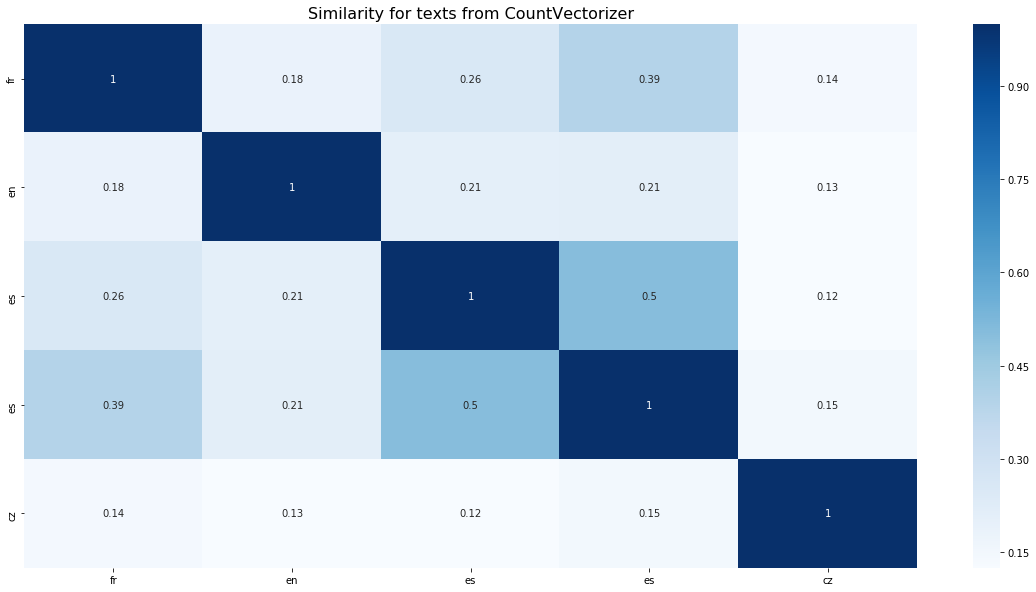

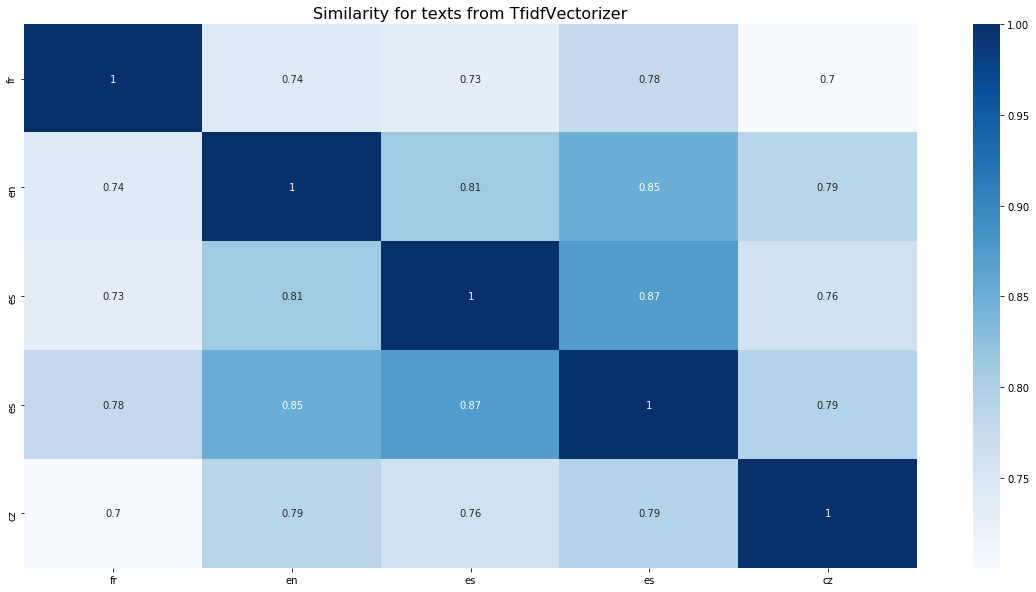

In [73]:
print(train.language.values[20:25])
for countvect_name, countvect in countvect_char_wb.items():
    sp_matrix = countvect.fit_transform(train.text.values[20:25], train.language.values[20:25])
    similarities = cosine_similarity(sp_matrix)
    lan = [languages[i] for i in train.language.values[20:25]]
    df_cm = DataFrame(similarities, columns=lan, index=lan)
    plt.figure(figsize=(20,10))
    plt.title('Similarity for texts from '+countvect_name, fontsize=16)
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.show()

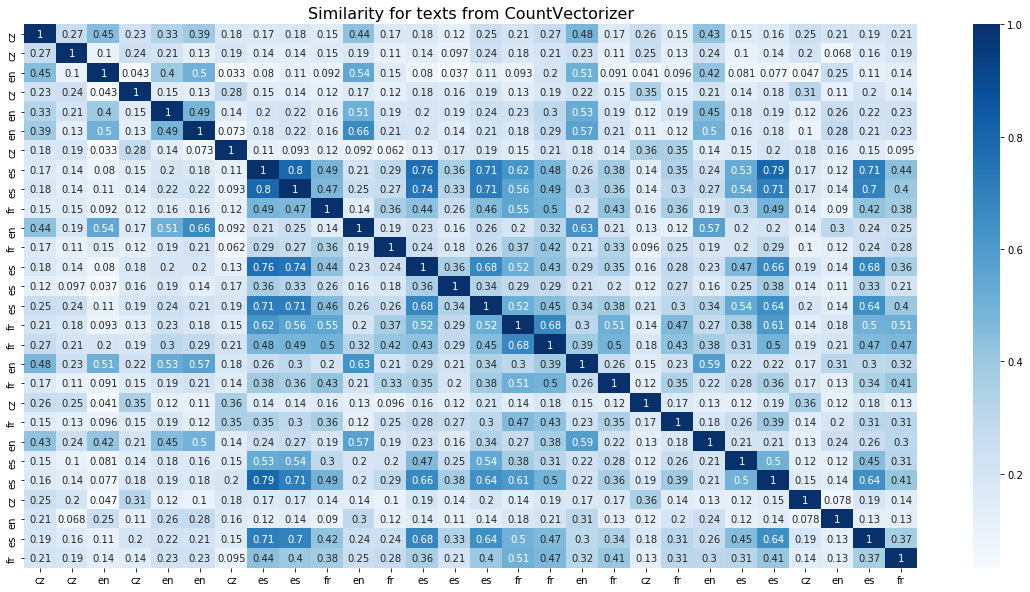

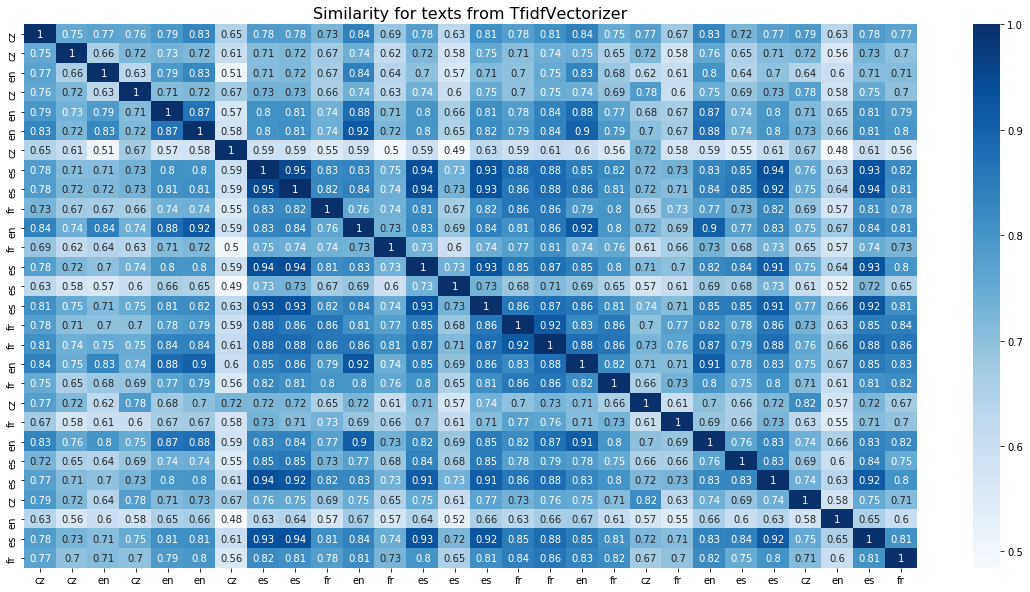

In [77]:
for countvect_name, countvect in countvect_char_wb.items():
    sp_matrix = countvect.fit_transform(train.text.values, train.language.values)
    similarities = cosine_similarity(sp_matrix)
    lan = [languages[i] for i in train.language.values]
    df_cm = DataFrame(similarities, columns=lan, index=lan)
    plt.figure(figsize=(20,10))
    plt.title('Similarity for texts from '+countvect_name, fontsize=16)
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.show()

In [71]:
for countvect_name, countvect in countvect_char_wb.items():
    for meth_name, meth in methods.items():
        char_model = Pipeline([('vect', countvect), ('select', select), ('logr', meth)])
        char_model.fit(train.text.values, train.language.values)
        print('=====================================================')
        print("Vectorizer : ", countvect_name)
        print("Method : ", meth_name)
        target_names = languages
        report = classification_report(test.language.values, char_model.predict(test.text.values), target_names=target_names)
        print(report)
        print("Micro F1-score : ", f1_score(char_model.predict(test.text.values), test.language.values, average='micro'))
        print('=====================================================')

Vectorizer :  CountVectorizer
Method :  LogisticRegression
             precision    recall  f1-score   support

         en       1.00      1.00      1.00         3
         fr       1.00      1.00      1.00         3
         cz       1.00      1.00      1.00         4
         es       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        12

Micro F1-score :  1.0
Vectorizer :  CountVectorizer
Method :  svm.LinearSVC
             precision    recall  f1-score   support

         en       1.00      1.00      1.00         3
         fr       0.75      1.00      0.86         3
         cz       1.00      1.00      1.00         4
         es       1.00      0.50      0.67         2

avg / total       0.94      0.92      0.91        12

Micro F1-score :  0.916666666667
Vectorizer :  CountVectorizer
Method :  svm.SVC
             precision    recall  f1-score   support

         en       1.00      1.00      1.00         3
         fr       0.75      1.00   